In [25]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import librosa
import librosa.display
from dataset import ALCDataset

%matplotlib inline

In [2]:
SR = 16000
SLICE = 5

### Load data

In [3]:
alc_dataset = ALCDataset('/Users/mazeyu/Desktop/CMU/20fall/18797/project/code/data')
data_train, meta_train = alc_dataset.load_data('train', percentage=1.0, num_threads=4)
data_train, meta_train = alc_dataset.slice_data(data_train, meta_train, SLICE)
data_dev1, meta_dev1 = alc_dataset.load_data('d1', percentage=1.0, num_threads=4)
data_dev1, meta_dev1 = alc_dataset.slice_data(data_dev1, meta_dev1, SLICE)
data_dev2, meta_dev2 = alc_dataset.load_data('d2', percentage=1.0, num_threads=4)
data_dev2, meta_dev2 = alc_dataset.slice_data(data_dev2, meta_dev2, SLICE)
data_test, meta_test = alc_dataset.load_data('test', percentage=1.0, num_threads=4)
data_test, meta_test = alc_dataset.slice_data(data_test, meta_test, SLICE)

In [4]:
assert len(data_train) == len(meta_train)
assert len(data_dev1) == len(meta_dev1)
assert len(data_dev2) == len(meta_dev2)
assert len(data_test) == len(meta_test)

print('#train: {}'.format(len(data_train)))
print('#dev1: {}'.format(len(data_dev1)))
print('#dev2: {}'.format(len(data_dev2)))
print('#test: {}'.format(len(data_test)))

#train: 9880
#dev1: 6760
#dev2: 2555
#test: 5220


### Feature extraction

In [5]:
class ALCFeature:
    def __init__(self, sr):
        self.sr = sr
        
    def get_mfcc(self, data, n_mfcc=20, scale=False, show=0):
        mfcc = []
        for i, audio in enumerate(data):
            mfcc_ = librosa.feature.mfcc(audio, sr=self.sr, n_mfcc=n_mfcc)
            if scale:
                mfcc_ = sklearn.preprocessing.scale(mfcc_, axis=1)
            if i < show:
                plt.figure()
                librosa.display.specshow(mfcc_, sr=self.sr, x_axis='time')
                plt.show()
            mfcc.append(mfcc_.flatten())
        mfcc = np.stack(mfcc, axis=0)
        return mfcc
    
    def get_cqt(self, data, wind_length, scale=False, show=0):
        cqt = []
        wind = np.hanning(int(wind_length * self.sr))
        for i, audio in enumerate(data):
            cqt_ = librosa.feature.chroma_cqt(audio, sr=self.sr, window=wind)
            if scale:
                cqt_ = sklearn.preprocessing.scale(cqt_, axis=1)
            if i < show:
                plt.figure()
                librosa.display.specshow(cqt_, sr=self.sr, x_axis='time')
                plt.show()
            cqt.append(cqt_.flatten())
        cqt = np.stack(cqt, axis=0)
        return cqt
    
    def pncc(self, data):
        pass

In [6]:
alc_feature = ALCFeature(SR)

x_train = alc_feature.get_mfcc(data_train)
x_dev1 = alc_feature.get_mfcc(data_dev1)
x_dev2 = alc_feature.get_mfcc(data_dev2)
x_test = alc_feature.get_mfcc(data_test)
y_train = meta_train
y_dev1 = meta_dev1
y_dev2 = meta_dev2
y_test = meta_test

In [11]:
pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_dev1 = pca.transform(x_dev1)
x_dev2 = pca.transform(x_dev2)
x_test = pca.transform(x_test)

### Classification model

In [33]:
class ALCModel:
    def __init__(self, method):
        if method == 'lr':
            self.clf = linear_model.LogisticRegression()
        elif method == 'svm':
            self.clf = SVC(C=1.0, kernel='rbf')
        elif method == 'forest':
            self.clf = RandomForestClassifier(n_estimators=100)
        elif method == 'adaboost':
            self.clf = AdaBoostClassifier(n_estimators=100)
        else:
            pass
        
    def fit(self, x, y):
        self.clf.fit(x, y)
    
    def predict(self, x):
        pred = self.clf.predict(x)
        return pred
    
    def evaluate(self, x, y, roc=False):
        pred = self.clf.predict(x)
        acc = self.clf.score(x, y)
        report = sklearn.metrics.classification_report(y, pred)
        if roc:
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.title('ROC Curve')
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.show()
        return acc, report

In [36]:
model = ALCModel('svm')
model.fit(x_train, y_train)

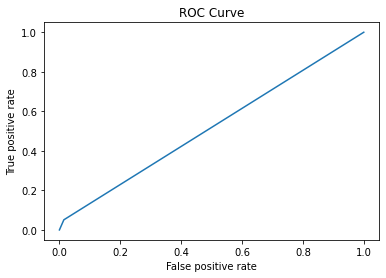

              precision    recall  f1-score   support

           0       0.50      0.99      0.66      2540
           1       0.79      0.05      0.10      2680

    accuracy                           0.51      5220
   macro avg       0.64      0.52      0.38      5220
weighted avg       0.65      0.51      0.37      5220



In [37]:
acc, report = model.evaluate(x_test, y_test, roc=True)
print(report)